In [12]:
import pandas as pd
import numpy as np
from py_files.data_manager import get_X_y
from py_files.features import distance, generate_features
from config import data_path
import json

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error, r2_score
import time
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
pd.options.display.float_format = '{:.6f}'.format

In [2]:
X, y = get_X_y(force_clean=True)
# X, y = get_X_y()
X = generate_features(X, y)
X['pickup_datetime'] = pd.to_datetime(X['pickup_datetime'])

/Users/dylanskinner/opt/anaconda3/envs/acme1/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator KMeans from version 1.2.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


In [4]:
X.head()

,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_month,pickup_day_Monday,pickup_day_Saturday,...,pickup_period_afternoon,pickup_period_evening,pickup_hour_sin,pickup_hour_cos,pickup_datetime_norm,distance_km,temperature_2m (°C),precipitation (mm),cloudcover (%),avg_cluster_duration
0,1,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,3,1,0,...,1,0,-0.965926,-0.258819,0.405086,2.208255,6.400000,0.200000,100.000000,814.728261
1,1,2016-03-14 17:19:42,1,-73.993095,40.747917,-74.006340,40.734406,3,1,0,...,1,0,-0.965926,-0.258819,0.405066,2.975163,6.400000,0.200000,100.000000,802.820588
2,1,2016-03-14 16:57:39,5,-73.979507,40.785347,-73.970268,40.799091,3,1,0,...,1,0,-0.866025,-0.500000,0.404982,2.555654,6.400000,0.200000,100.000000,827.276087
3,1,2016-03-14 17:01:41,1,-73.984245,40.749043,-73.999893,40.734074,3,1,0,...,1,0,-0.965926,-0.258819,0.404997,3.404428,6.400000,0.200000,100.000000,893.413174
4,1,2016-03-14 17:16:07,1,-74.006760,40.705559,-73.980568,40.787540,3,1,0,...,1,0,-0.965926,-0.258819,0.405052,12.028330,6.400000,0.200000,100.000000,687.900000


/Users/dylanskinner/opt/anaconda3/envs/acme1/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


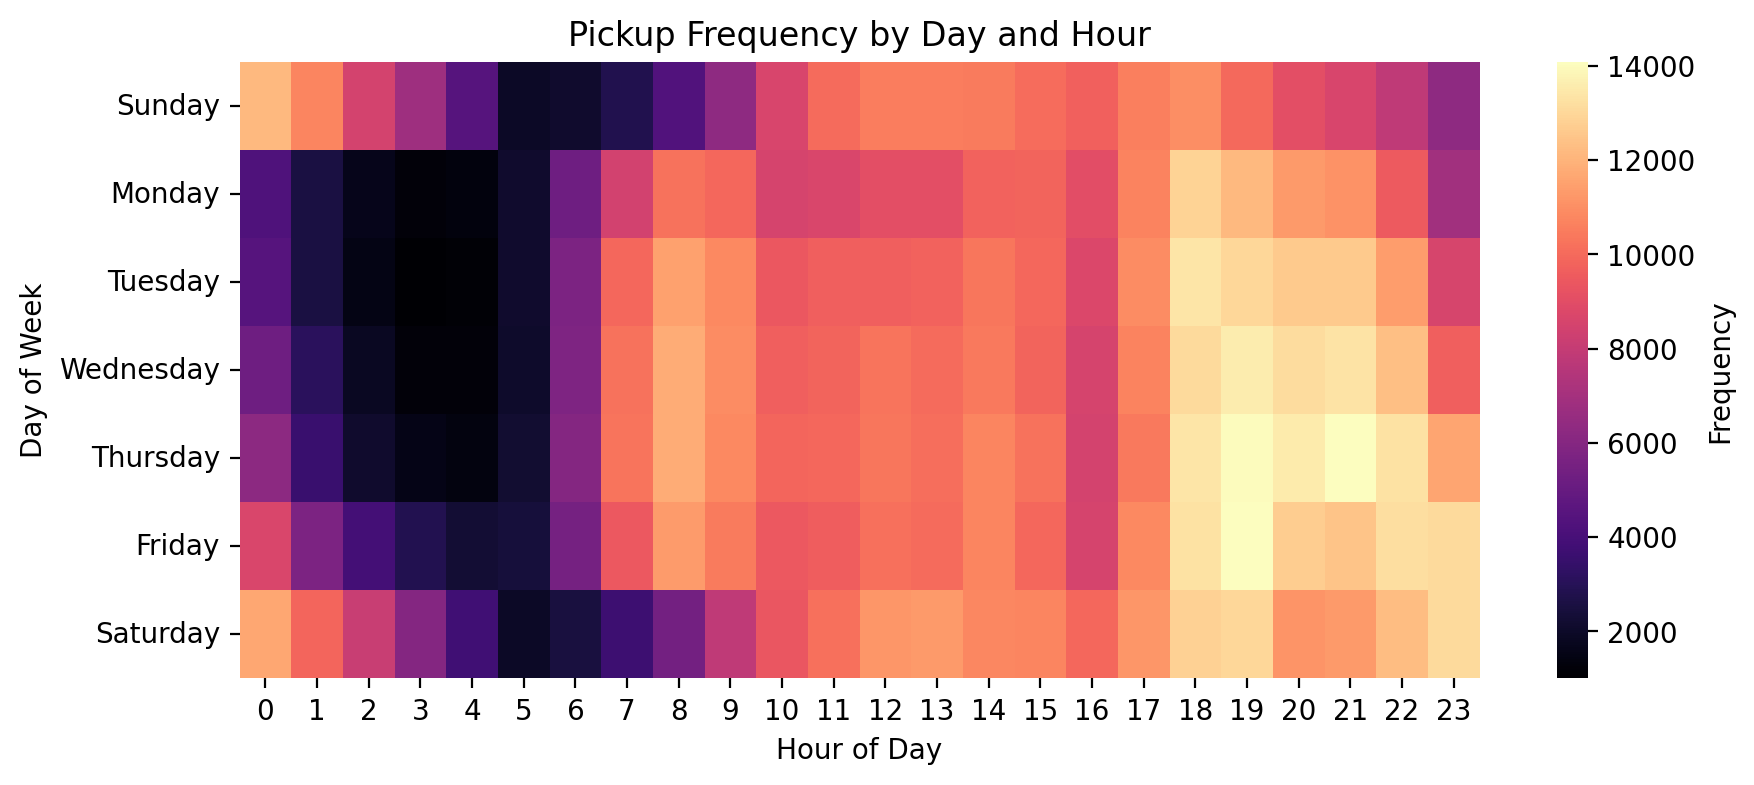

<Figure size 640x480 with 0 Axes>

In [32]:
# Create heatmap for frequency between days and hours.
# Get data
day_hour = X[['pickup_datetime', 'pickup_hour']]

# Create new column for day of the week
day_hour['day_of_week'] = day_hour['pickup_datetime'].dt.day_name()

# Define the order of days
day_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

pivot_table = day_hour.pivot_table(index='day_of_week', columns='pickup_hour', aggfunc='size', fill_value=0)
pivot_table.sort_index(ascending=False, inplace=True)
pivot_table = pivot_table.reindex(day_order)
pivot_table

# Create the heatmap using seaborn
plt.figure(figsize=(10, 4), dpi=200)
sns.heatmap(pivot_table, cmap='magma', fmt='d', cbar_kws={'label': 'Frequency'})
plt.title('Pickup Frequency by Day and Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.savefig('images/day_hour.png')
plt.show()

plt.savefig('images/day_hour.png')

# day_hour.head()


In [20]:
from sklearn import linear_model
from sklearn.linear_model import LassoLarsIC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

X1 = X.drop(columns=['id', 'vendor_id', 'pickup_datetime'])

# Get test train split
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=42)

lasso_lars_ic = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC(criterion="bic", normalize=False)).fit(X_train, y_train)

results = pd.DataFrame(
    {
        "alphas": lasso_lars_ic[-1].alphas_,
        "BIC criterion": lasso_lars_ic[-1].criterion_,
    }
).set_index("alphas")

optimal_alpha = results[results['BIC criterion'] == results['BIC criterion'].min()].index

# Train a Lasso model with the optimal alpha for feature selection
lasso = linear_model.Lasso(alpha=optimal_alpha)
lasso.fit(X_train, y_train)
print(lasso.coef_.round(4))
print(f"Imporant columns: {X_train.columns[lasso.coef_ != 0]}")
print(f'R-squared: {r2_score(y_test, lasso.predict(X_test))}')
pd.DataFrame({'Actual': y_test, 'Predicted': lasso.predict(X_test)})['Predicted'].describe()

[-0.     -0.      0.     -0.     -0.      0.0778 -0.      0.      0.
 -0.     -0.      0.      0.0162  0.0159 -0.      0.     -0.     -0.
 -0.      0.     -0.0367 -0.      0.      0.013 ]
Imporant columns: Index(['pickup_month', 'pickup_hour', 'pickup_minute', 'distance_km',
       'cloudcover (%)'],
      dtype='object')
R-squared: -2.604232092195957e-07


count   288533.000000
mean       827.295981
std          0.642269
min        795.683504
25%        826.833082
50%        827.268480
75%        827.775059
max        828.970851
Name: Predicted, dtype: float64

In [22]:
pd.Series(y_pred).describe()

count   288533.000000
mean       743.743891
std          6.167586
min        650.174214
25%        742.077454
50%        744.052191
75%        744.967307
max        936.741040
dtype: float64

In [32]:
X1 = X.drop(columns=['id', 'vendor_id', 'pickup_datetime'])

# Get test train split
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=42)

# Create param grid
param_grid = {
    'boosting_type': ['gbdt', 'dart'],
    'num_leaves': [30, 40],
    'learning_rate': [0.01, 0.05],
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'reg_alpha': [0.1, 0.5],
    'reg_lambda': [0.1, 0.5],
}

# LightGBM
lgb_train = lgb.LGBMRegressor()

# Grid search
grid_search = GridSearchCV(estimator=lgb_train, param_grid=param_grid, cv=3, scoring='neg_root_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train)

# Best params
print('Best parameters from grid search: ', grid_search.best_params_)


Fitting 3 folds for each of 128 candidates, totalling 384 fits
Best parameters from grid search:  {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 20, 'n_estimators': 100, 'num_leaves': 30, 'reg_alpha': 0.1, 'reg_lambda': 0.1}


In [41]:
# Run light gbm on the best params with best features
X2 = X1[['pickup_month', 'pickup_hour', 'pickup_minute', 'distance_km', 'cloudcover (%)']]
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=42)
params = {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'max_depth': 20, 'n_estimators': 100, 'num_leaves': 30, 'reg_alpha': 0.1, 'reg_lambda': 0.1}

lgb_best = lgb.LGBMRegressor(**params)
lgb_best.fit(X_train, y_train)
y_pred = lgb_best.predict(X_test)
print(f'R-squared X1: {r2_score(y_test, y_pred)}')
print(f'RMSLE X1: {mean_squared_log_error(y_test, y_pred, squared=False)}')

X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=42)
lgb_best = lgb.LGBMRegressor(**params)
lgb_best.fit(X_train, y_train)
y_pred = lgb_best.predict(X_test)
print(f'R-squared X2: {r2_score(y_test, y_pred)}')
print(f'RMSLE X2: {mean_squared_log_error(y_test, y_pred, squared=False)}')

R-squared X1: -2.66374427706495e-05
RMSLE X1: 0.7612960832486187
R-squared X2: -2.5227822131324018e-05
RMSLE X2: 0.7612910686040159


In [43]:
# Keep only pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, pickup_month, pickup_hour, pickup_period, distance
# X_c = X[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
#             'pickup_month', 'pickup_hour', 'pickup_period', 'distance_km']]
# X_c = pd.get_dummies(X_c, columns=['pickup_period'], drop_first=True)
# X = X.drop(columns=['id', 'pickup_datetime'])

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestRegressor(n_estimators=100, max_depth=6, n_jobs=1, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)
print(mean_squared_log_error(y_test, y_pred, squared=False))


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  6.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.7612956933912876


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished


In [45]:
# Try log transformation of y
y_log = np.log(y)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X1, y_log, test_size=0.2, random_state=42)

# Run xgboost regressor on the data.
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=6, n_jobs=1, random_state=42)
xgb_reg.fit(X_train, y_train)

# Predict
y_pred = xgb_reg.predict(X_test)
print(mean_squared_log_error(np.exp(y_test), y_pred, squared=True))

20.416757344607447


In [49]:
print(mean_squared_log_error(np.exp(y_test), np.exp(y_pred), squared=False))

0.7208240949347663


In [51]:
pd.DataFrame({'Actual': np.exp(y_test), 'Predicted': np.exp(y_pred)})

,Actual,Predicted
1398060,289.000000,646.015686
274944,659.000000,651.532166
1043220,733.000000,645.393738
769154,731.000000,637.844238
1258561,1242.000000,647.302734
...,...,...
1188211,476.000000,646.208557
197210,583.000000,651.900391
1355987,352.000000,640.801025
106607,262.000000,634.399963


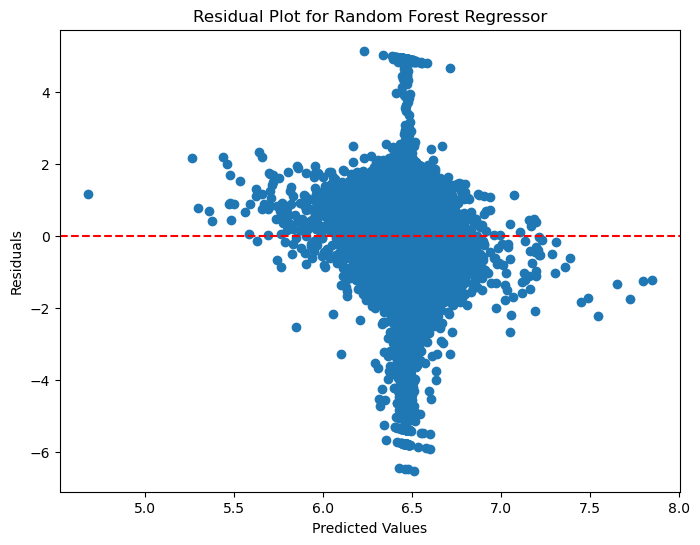

In [40]:
# Calculate residuals
residuals = y_test - y_pred

# Create a residual plot
plt.figure(figsize=(8, 6))
plt.scatter(x=y_pred, y=residuals)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot for Random Forest Regressor")
plt.show()

In [127]:
json_file_path = './misc/lat_long_bounds.json'
with open(json_file_path, 'r') as json_file:
    # Load the JSON data from the file
    coords = json.load(json_file)
coords

{'lat': {'min': 40.49787800728235, 'max': 40.91510319260631},
 'lon': {'min': -74.25495645300373, 'max': -73.70002020503291},
 'code_str': '\nnyc_df = pd.read_csv(f"{data_path}/Centerline.csv")\nnyc_df = nyc_df.loc[:, [\'the_geom\']]\n\n# Convert the "the_geom" column to Shapely geometries\nnyc_df[\'the_geom_geopandas\'] = nyc_df[\'the_geom\'].apply(loads)\n\n# Create a GeoDataFrame\ngdf = gpd.GeoDataFrame(nyc_df, geometry=\'the_geom_geopandas\')\n\nmin_lon, min_lat, max_lon, max_lat = gdf[\'the_geom_geopandas\'].total_bounds\n'}

# Get rid of outlier variables

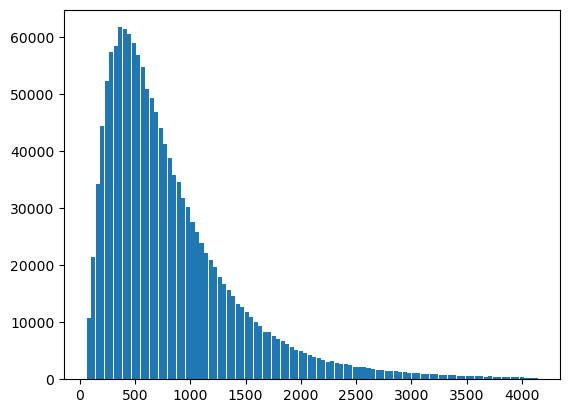

In [8]:
plt.hist(y, bins=100, rwidth=0.9)
plt.show()

(1442663, 24)
(1442663, 24)
(1435463, 24)
(1442663, 27)


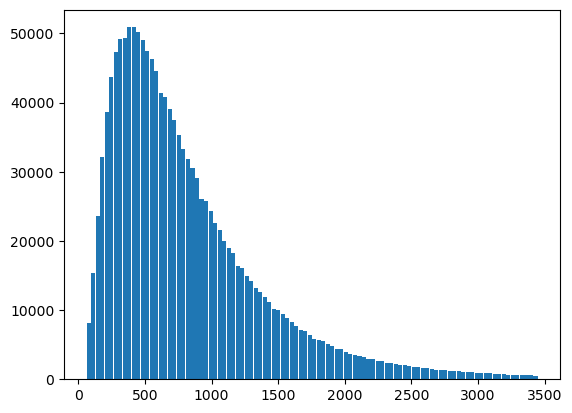

count   1435463.000000
mean        812.408177
std         574.502822
min          60.000000
25%         399.000000
50%         660.000000
75%        1061.000000
max        3448.000000
Name: trip_duration, dtype: float64

In [4]:
# Read in raw data
df = pd.read_csv(data_path + '/train_clean.csv')

# Drop trips less than 60 seconds
df = df[df['trip_duration'] >= 60]

# Get coordinates from json
json_file_path = './misc/lat_long_bounds.json'
with open(json_file_path, 'r') as json_file:
    # Load the JSON data from the file
    coords = json.load(json_file)

# Get rid of lat long outliers
print(df.shape)
df = df[(df['pickup_latitude'] >= coords['lat']['min']) & (df['pickup_latitude'] <= coords['lat']['max'])]
df = df[(df['pickup_longitude'] >= coords['lon']['min']) & (df['pickup_longitude'] <= coords['lon']['max'])]

# Keep only <99.5% of trip duration
print(df.shape)
df1 = df[df['trip_duration'] <= df['trip_duration'].quantile(0.995)]
print(df1.shape)
print(X.shape)

# Plot histogram of trip duration
plt.hist(df1['trip_duration'], bins=100, rwidth=0.9)
plt.show()

df1.trip_duration.describe()


In [81]:
# Train test split
X_c = X.drop(columns=['pickup_datetime'])
X_c = pd.get_dummies(X_c, columns=['pickup_period'], drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X_c, y, test_size=0.2, random_state=42)

# Grid search for XGBoost
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [6, 8],
    'learning_rate': [0.1, 0.2],
    'min_child_weight': [1, 2],
    'lambda': [0.5, 0.4],
    'alpha': [0.5, 0.4],
    'objective': ['reg:squarederror', 'reg:squaredlogerror']
}
xgb_model = xgb.XGBRegressor()

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=4, n_jobs=-1)
grid_search.fit(X_train, y_train)



# Evaluate based on Root Mean Squared Logarithmic Error.
y_pred = grid_search.predict(X_test)
print(mean_squared_log_error(y_test, y_pred, squared=False))


0.525662602679601


<h3>Doing some basic data analysis</h3>

Task:
<ul>
<li>✅ Get most common pickup and dropoff locations.</li>
<li>Find the number of rows and columns</li>
<li>Find the data statistics</li>
</ul>

In [49]:
# Get the most common pickup longitude and latitude
pop_p_lat = X_c.pickup_latitude.value_counts().index[0]
pop_p_long = X_c[X_c.pickup_latitude == pop_p_lat].pickup_longitude.value_counts().index[0]

# Most common pickup location
com_pickup = (pop_p_lat, pop_p_long)  # This is actually the airport, so that makes sense.

# Get the most common dropoff latitude and longitude 
pop_d_lat = X_c.dropoff_latitude.value_counts().index[0]
pop_d_long = X_c[X_c.dropoff_latitude == pop_d_lat].dropoff_longitude.value_counts().index[0]

# Most common dropoff location
com_dropoff = (pop_d_lat, pop_d_long)  # This is actually the airport, so that makes sense.
com_dropoff

(40.774311, -73.872787)

In [53]:
# Find most common drop off location when pickup location is the airport
drop_lat_after_aiport = X_c[(X_c.pickup_latitude == pop_p_lat) & (X_c.pickup_longitude == pop_p_long)].dropoff_latitude.value_counts()#.index[0]
# drop_long_after_aiport = X_c[X_c.pickup_latitude == pop_p_lat][X_c.dropoff_latitude == drop_lat_after_aiport].dropoff_longitude.value_counts().index[0]
drop_lat_after_aiport

40.668980    1
40.673012    1
40.757832    1
40.642849    1
40.762131    1
40.738796    1
40.750011    1
40.783730    1
40.691589    1
40.802757    1
40.758480    1
40.770809    1
Name: dropoff_latitude, dtype: int64